<a href="https://colab.research.google.com/github/harim061/FakeNewsDetection/blob/main/fakeNews_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 메소드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
!pip install contractions
import contractions
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_score, \
                             recall_score, f1_score, roc_curve, \
                             accuracy_score, roc_auc_score
from sklearn.model_selection import ParameterGrid, GridSearchCV


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.layers import  Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

from __future__ import absolute_import, division, print_function, unicode_literals

VOCAB_SIZE = 5000

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
path = '/content/drive/MyDrive/kaggle_data/'
test= pd.read_csv(path + 'test.csv'  )
train= pd.read_csv(path + 'train.csv' )
submit= pd.read_csv(path + 'submit.csv')

# 데이터 전처리

In [36]:
def data_clean(dt):
  dt = dt.fillna('')
  dt["total"] = dt['title'] + " " + dt["author"]
  return dt

In [8]:

def text_cleaning(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(len(df)):
        m = re.sub("[^a-zA-Z]", " ", df["total"][i])
        m = m.lower()
        m = m.split()
        m = [ps.stem(word) for word in m if not word in stopwords.words('english')]
        clean_text = " ".join(m)
        corpus.append(clean_text)
    return corpus


In [9]:
def onehot(corpus, VOCAB_SIZE = 5000):
  return [one_hot(words, VOCAB_SIZE) for words in corpus]

In [10]:
def padding(onehot_text) :
  return np.array(pad_sequences(onehot_text, padding="pre", maxlen = 25))

In [11]:
def get_label(df):
  return np.array(df["label"])

In [12]:
def make_clean(df) :
  corpus = data_clean(df)
  corpus = text_cleaning(corpus)
  corpus = onehot(corpus)
  corpus = padding(corpus)
  return   corpus

In [13]:
def get_data() :
  path = '/content/drive/MyDrive/kaggle_data/'
  test   = pd.read_csv(path + 'test.csv'  )
  train  = pd.read_csv(path + 'train.csv' )
  submit = pd.read_csv(path + 'submit.csv')

  x = np.array(list(make_clean(train)) + list(make_clean(test )))
  y = np.array(list(get_label(train )) + list(get_label(submit)))
  return train_test_split(x, y, test_size = 0.1, random_state = 1234)

In [14]:

def save_data(path, train_x, test_x, train_y, test_y) :
  np.save(path + 'train_x', train_x)
  np.save(path + 'test_x' , test_x )
  np.save(path + 'train_y', train_x)
  np.save(path + 'test_y' , test_x )

In [15]:

train_x, test_x, train_y, test_y = get_data()

save_data(path, train_x, test_x, train_y, test_y)

In [16]:
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,test_size = 0.1,random_state = 1234)

In [17]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(21060, 25)
(21060,)
(2340, 25)
(2340,)
(2600, 25)
(2600,)


# 모델링 - CNN-LSTM

In [18]:
train_x.shape

(21060, 25)

In [20]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(keras.layers.Embedding(30000, 30))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(keras.layers.Conv1D(32, 3, padding='same', strides=1,activation='relu'))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(2))
model_CNN_LSTM.add(LSTM(100))
model_CNN_LSTM.add(keras.layers.Dropout(0.3))
model_CNN_LSTM.add(Dense(1, activation='sigmoid'))
model_CNN_LSTM.compile(optimizer = 'Adam', loss='binary_crossentropy', metrics=['acc'])
history_CNN_LSTM = model_CNN_LSTM.fit(train_x, train_y, epochs=10,
                    validation_data=(val_x, val_y))
model_CNN_LSTM.summary()



Epoch 1/10
659/659 [==============================] - 36s 48ms/step - loss: 0.3286 - acc: 0.8784 - val_loss: 0.2661 - val_acc: 0.9120
Epoch 2/10
659/659 [==============================] - 27s 42ms/step - loss: 0.2477 - acc: 0.9188 - val_loss: 0.2619 - val_acc: 0.9150
Epoch 3/10
659/659 [==============================] - 23s 34ms/step - loss: 0.2217 - acc: 0.9266 - val_loss: 0.2683 - val_acc: 0.9124
Epoch 4/10
659/659 [==============================] - 21s 32ms/step - loss: 0.1993 - acc: 0.9321 - val_loss: 0.2788 - val_acc: 0.9043
Epoch 5/10
659/659 [==============================] - 24s 36ms/step - loss: 0.1779 - acc: 0.9385 - val_loss: 0.3122 - val_acc: 0.9026
Epoch 6/10
659/659 [==============================] - 22s 33ms/step - loss: 0.1570 - acc: 0.9442 - val_loss: 0.3192 - val_acc: 0.8940
Epoch 7/10
659/659 [==============================] - 22s 34ms/step - loss: 0.1348 - acc: 0.9516 - val_loss: 0.3608 - val_acc: 0.8825
Epoch 8/10
659/659 [==============================] - 21s 32ms

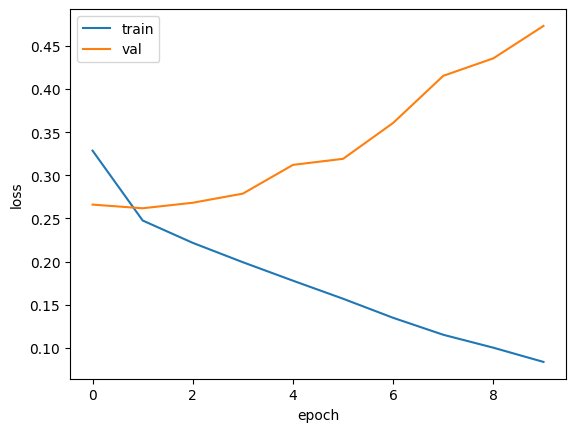

In [21]:
plt.plot(history_CNN_LSTM.history['loss'])
plt.plot(history_CNN_LSTM.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [22]:
model_CNN_LSTM.evaluate(val_x, val_y)

74/74 [==============================] - 1s 15ms/step - loss: 0.4732 - acc: 0.8628


[0.4732479751110077, 0.8628205060958862]

# test set 예측

In [23]:
def show_metrics(y_pred, y_actual) :
  print('Accuracy  :',  accuracy_score(y_pred, y_actual))
  print('Precision :', precision_score(y_pred, y_actual))
  print('Recall    :',    recall_score(y_pred, y_actual))
  print('F1-score  :',        f1_score(y_pred, y_actual))
  print('Auc       :',   roc_auc_score(y_pred, y_actual))


In [24]:
def show_confusion_matrix(y_pred, y_actual, path, model_name) :
  fig = plt.figure(figsize = (10, 8))
  plt.title(model_name + ' Confusion Matrix')
  sns.heatmap(confusion_matrix(y_pred, y_actual), annot = True, fmt = 'd',
              cbar = False, cmap = sns.color_palette("Purples",2),
              xticklabels = ['Positive', 'Negative'],
              yticklabels = ['Positive', 'Negative'])
  plt.xlabel('Actuals')
  plt.ylabel('Predicted')
  plt.savefig(path + model_name +'_confusion_matrix.png', dpi = 300)
  plt.show()

In [26]:
model_CNN_LSTM.evaluate(test_x,test_y)

82/82 [==============================] - 1s 10ms/step - loss: 0.5025 - acc: 0.8588


[0.5025308728218079, 0.858846127986908]

In [27]:
y_pred = (model_CNN_LSTM.predict(test_x) > 0.5).astype("int32")
path2 = '/content/drive/MyDrive/ML2/'
model_CNN_LSTM.save(path2 + 'CNN_LSTM.h5')

82/82 [==============================] - 4s 16ms/step


Accuracy  : 0.8588461538461538
Precision : 0.8683812405446294
Recall    : 0.8560775540641312
F1-score  : 0.8621855050694704
Auc       : 0.8589363147604214


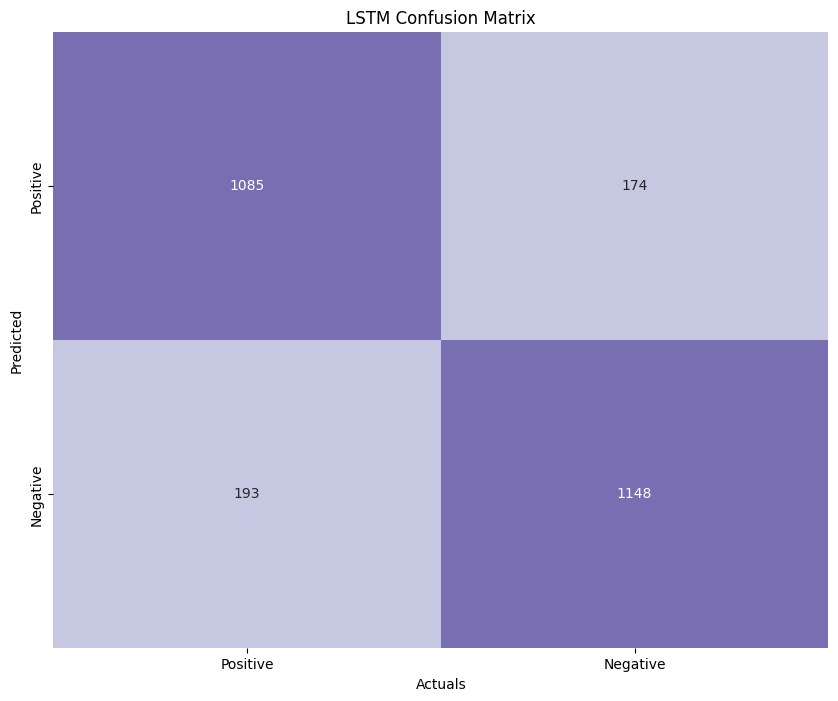

In [28]:
show_metrics(y_pred, test_y)
show_confusion_matrix(y_pred, test_y, path2, 'LSTM')

# 새로운 문장 예측

In [44]:
def get_prediction_from_user():
    while True:
        # 사용자에게 뉴스 제목을 입력받습니다.
        title = input("뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.): ")

        # 입력받은 제목이 '0'이라면 함수를 종료합니다.
        if title == '0':
            print("Program terminated.")
            break

        # 사용자에게 뉴스 내용을 입력받습니다.
        content = input("뉴스 내용을 입력하세요: ")

        # 입력받은 제목과 내용을 데이터프레임으로 만듭니다.
        user_df = pd.DataFrame([[title, content]], columns=["title", "author"])

        # 데이터를 전처리합니다.
        user_data_clean = data_clean(user_df)
        user_corpus = text_cleaning(user_data_clean)
        user_onehot_text = onehot(user_corpus)
        user_tokens_pad = padding(user_onehot_text)

        # 예측을 수행합니다.
        prediction = model_CNN_LSTM.predict(user_tokens_pad)

        # 예측 결과를 출력합니다.
        if prediction > 0.5:
            print("This news is likely to be fake.")
        else:
            print("This news is likely to be real.")
        print(prediction)

# 함수를 실행합니다.
get_prediction_from_user()

뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.): Trump Withdraws U.S. From 'One-Sided' Paris Climate Accord
뉴스 내용을 입력하세요: President Trump announced on Thursday that the United States would withdraw from the Paris climate accord, weakening efforts to combat global warming and embracing isolationist voices in his White House who argued that the agreement was a pernicious threat to the economy and American sovereignty. In a speech from the Rose Garden, Mr. Trump said the landmark 2015 pact imposed wildly unfair environmental standards on American businesses and workers. He vowed to stand with the people of the United States against what he called a “draconian” international deal.
1/1 [==============================] - 0s 24ms/step
This news is likely to be real.
[[0.37099576]]
뉴스 제목을 입력하세요 (0을 입력하면 종료됩니다.): Aliens Discovered Living Among Us, NASA Confirms
뉴스 내용을 입력하세요: In a shocking revelation today, NASA has confirmed that aliens have been living among us for years. They have been disguising themselves as